In this notebook the dataset of the hourly taxi demand is analyzed and the predictions of the models are compared. 

## Load Modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import statsmodels.api as sm


import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import gridspec

from descartes import PolygonPatch

import seaborn as sns
#plt.style.use('seaborn-whitegrid')

#import bokeh, bokeh.plotting, bokeh.models
#from bokeh.io import output_notebook, show
#output_notebook()

import copy

#import folium
#import folium.plugins

import datetime

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error

import itertools

import os
#from tqdm import tqdm


import random

import math


## Load Files

In [3]:
#load predictions of models:
df_2year_train_PATH = '/media/..'

ARIMA_PATH = '/media/..'

#get predictions of each model:
ARIMA_2404_preds_20largest_areas__2years = pd.read_csv(ARIMA_PATH + 'ARIMA_2404_model_diff_1_168_24_20largest_areas__2year_train_09_10_preds.csv', parse_dates = ['date'], index_col='date')
Naive_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'Naive_model_20largest_areas__preds_all_years.csv', parse_dates = ['date'], index_col='date')
canary_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'Canary_model_clipped_output_20largest_areas__preds_all_years.csv', parse_dates = ['date'], index_col='date')

simple_MLP_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'simple_MLP_20largest_areas__preds_all_years.csv', parse_dates = ['date'], index_col='date')
complex_MLP_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'complex_MLP_20largest_areas__preds_all_years.csv', parse_dates = ['date'], index_col='date')

multivar_LSTM_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'multivar_LSTM_2H_256_32__20largest_areas__preds_all_years.csv', parse_dates = ['date'], index_col='date')
multivar_LSTM_encoded_lag_feats_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'multivar_LSTM_20largest_areas_encoded_lag_feat_added__preds_all_years.csv', parse_dates = ['date'], index_col='date')

single_LSTM_preds_20largest_areas__2years  = pd.read_csv(df_2year_train_PATH + 'single_LSTM_20largest_areas__preds_all_years.csv', parse_dates = ['date'], index_col='date')

Shape_PATH = '/media/..'





In [4]:
#load data files:
TRAIN_PATH = '/media/..'
Store_PATH = '/media/..'
file_final = 'preprocessed_data.csv'

df_m = pd.read_csv(TRAIN_PATH + file_final, header=0)
#df_m = pd.read_csv(file_final)
print(df_m.head())

#convert to datetime format:
df_m['date'] = pd.to_datetime(df_m['date'], utc=True)
df_m['date'] = df_m['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_m['date'] = pd.to_datetime(df_m['date'])
#df_m = df_m.set_index("date") -> set index later, since we need "date" column to find highest demand columns..
print(df_m.head())



#read in taxi_zone files:
taxi_zones_df = pd.read_csv(Shape_PATH + 'taxi+_zone_lookup.csv', header=0)

taxi_shapefile = gpd.read_file(Shape_PATH + 'taxi_zones.shp')
taxi_shapefile.drop(['OBJECTID', "Shape_Area", "Shape_Leng"],
                  axis=1, inplace=True)

taxi_shapefile = taxi_shapefile.to_crs({'init': 'epsg:4326'})

                        date  1  2  3    4  5  6   7  8  9  ...  254  255  \
0  2009-01-01 00:00:00-05:00  0  0  0   91  0  0  30  0  0  ...    0   50   
1  2009-01-01 01:00:00-05:00  1  0  0  105  0  0  62  0  0  ...    0   77   
2  2009-01-01 02:00:00-05:00  0  0  0   96  0  0  79  0  0  ...    0   90   
3  2009-01-01 03:00:00-05:00  0  0  0   91  0  0  84  0  0  ...    0   54   
4  2009-01-01 04:00:00-05:00  2  0  0   82  0  0  85  0  1  ...    0   66   

   256  257  258  259  260  261  262  263  
0   39    3    1    0    3   52  127  326  
1   67    5    0    0   15   65  166  476  
2   83    4    0    0   19   39  125  460  
3   77    3    1    0   19   54   79  313  
4   54    4    0    0   13   24   47  224  

[5 rows x 264 columns]
                 date  1  2  3    4  5  6   7  8  9  ...  254  255  256  257  \
0 2009-01-01 05:00:00  0  0  0   91  0  0  30  0  0  ...    0   50   39    3   
1 2009-01-01 06:00:00  1  0  0  105  0  0  62  0  0  ...    0   77   67    5   
2 2009-01

In [5]:
def get_nlargest_areas(nlargest, dataset_org = df_m):
    
    dataset_org_copy = dataset_org.copy()
    
    '''filter areas with highest demand '''
    #get time series with highest "demand patterns":
    df_sum = dataset_org_copy.copy(deep=True).drop(columns=["date"],axis=1)
    df_sum = df_sum.sum(axis=0,numeric_only=True)
    #store "n" largest values:
    df_sum = df_sum.nlargest(nlargest) 
    idx_filter = list(df_sum.index.values)
    #append "date" column
    idx_filter.append("date")

    del df_sum

    #filter columns with "n" largest values:
    ts_largest = dataset_org_copy[idx_filter].copy(deep=True)
    ts_largest = ts_largest.set_index("date")
    #set index correctly to local time:
    ts_largest.index = ts_largest.index.shift(-5,freq='H')
    
    return ts_largest
    

In [6]:
'''filter areas with highest demand '''
ts_10largest = get_nlargest_areas(10)
ts_20largest = get_nlargest_areas(20)

print(ts_20largest.head())

                     237  161  230   79  236  162  170  234   48  186  142  \
date                                                                         
2009-01-01 00:00:00  331  339   38  551  290  190  357  416  443  225  315   
2009-01-01 01:00:00  323  220   90  565  273  257  472  317  312  218  354   
2009-01-01 02:00:00  210  172  119  497  243  241  437  222  366  217  289   
2009-01-01 03:00:00  133  108  231  563  172  238  354  253  390  191  207   
2009-01-01 04:00:00   55   79  229  524   70  128  176  217  288  125  135   

                     107  163   68  239  164  141  249  138   90  
date                                                              
2009-01-01 00:00:00  391  164  374  338  241  370  321   49  287  
2009-01-01 01:00:00  461  147  283  411  232  461  239   23  193  
2009-01-01 02:00:00  414  148  291  374  227  408  251    4  204  
2009-01-01 03:00:00  412  143  281  241  250  310  204    2  221  
2009-01-01 04:00:00  254  115  230  151  164  185  

## Analysis of demand data

### Get Rides of Uber & Lyft

In [6]:
#read in FHV data:
#Note: important to read 'Year' & 'Month' in lower case --> this way can be converted to datetime 
#important to convert ',' for thousands
df_FHV = pd.read_csv(TRAIN_PATH + 'FHV.csv', header=0,  usecols=[1,3,4,6,7], names=['Provider', 'year', 'month','n_dispatched', 'n_shared'], thousands=',')

#create artificial days column to parse dates correctly:
df_FHV['day'] = 1

#add datetime to df:
df_FHV['date'] = pd.to_datetime(df_FHV[['year','month','day']])

#drop Year, Month & day columns:
df_FHV.drop(['year','month','day'], axis=1, inplace=True)

#get total amount of taxi drives/requests: (assuming shared & dispatched are different rides)
df_FHV['total_rides'] = df_FHV['n_dispatched'].astype(int) + df_FHV['n_shared'].astype(int)

#drop columns:
df_FHV.drop(['n_dispatched','n_shared'], axis=1, inplace=True)

#set new index:
df_FHV.set_index('date', inplace=True)

#sort index:
df_FHV = df_FHV.sort_index()

In [8]:
df_FHV.head()

,Provider,total_rides
date,,
2015-01-01,BROOKLYN RAD DISP INC,21699
2015-01-01,BELL RADIO INC,6071
2015-01-01,"VALERA GLOBAL, INC.",4816
2015-01-01,NEW COLLEGE CAR SVCE INC,29585
2015-01-01,DELANCEY TRANSPORTATION INC.,23891


In [7]:
#filter UBER rides:
df_FHV_uber = df_FHV[df_FHV['Provider'].isin(['UBER','uber','Uber'])]

df_FHV_uber.head()

#filter Lyft rides:
df_FHV_lyft = df_FHV[df_FHV['Provider'].isin(['Lyft','lyft','LYFT'])]

df_FHV_lyft.head()


,Provider,total_rides
date,,
2015-04-01,LYFT,80613
2015-05-01,LYFT,100862
2015-06-01,LYFT,111111
2015-07-01,LYFT,194815
2015-08-01,LYFT,318717


### Plots of NYC taxi demand:

#### Plot Taxi Requests vs Uber across all areas

In [8]:
#resample df_m on months (since we only have Uber drives per month):

#necessary to set index of df_m:
df_m_all_yellow = df_m.set_index("date").copy()
#set index correctly to local time:
df_m_all_yellow.index = df_m_all_yellow.index.shift(-5,freq='H')

df_m_monthly = df_m_all_yellow.resample('M').sum().copy()

#get sum 
df_m_monthly_sum = pd.DataFrame(df_m_monthly.sum(axis=1),columns=['total_sum_rides'])

In [11]:
df_m_monthly_sum.shape

(114, 1)

In [12]:
df_m_monthly_sum.head()

,total_sum_rides
date,
2009-01-31,10317751
2009-02-28,11347389
2009-03-31,11831629
2009-04-30,10035919
2009-05-31,10331532


In [9]:
#get total sum of rides (yellow cabs + FHV drives combined):

#get sum per Provider:
df_FHV_total_rides_month = df_FHV.groupby(['Provider']).resample('M').sum()

#get sum among all providers df:
df_FHV_total_rides_month_new = df_FHV_total_rides_month.reset_index()

#get total sum of rides among all provides:
df_FHV_total_rides_month_new_sum = df_FHV_total_rides_month_new.groupby(['date']).sum()


In [10]:
#get total sum among all providers:
df_FHV_total_rides_month_all_providers = df_FHV.resample('M').sum()
df_FHV_total_rides_month_all_providers.head()

,total_rides
date,
2015-01-31,2699237
2015-02-28,3023546
2015-03-31,3216261
2015-04-30,3823273
2015-05-31,3336998


In [11]:
#fast way to get sum of all providers:
df_FHV_total_rides_month_sum_all = df_FHV.resample('M').sum()

In [12]:
#add sum of providers to yellow cab rides:
total_rides_df = pd.concat([df_m_monthly_sum['total_sum_rides'], df_FHV_total_rides_month_sum_all['total_rides']], axis=1)

#replace "NaN" by "0"
total_rides_df.fillna(0, inplace=True)

In [13]:
#get total sum:
total_rides_df['overall_sum'] = total_rides_df['total_sum_rides'] + total_rides_df['total_rides']

In [14]:
total_rides_df.tail()

,total_sum_rides,total_rides,overall_sum
date,,,
2018-07-31,0.0,26642523.0,26642523.0
2018-08-31,0.0,27278458.0,27278458.0
2018-09-30,0.0,27290316.0,27290316.0
2018-10-31,0.0,28693262.0,28693262.0
2018-11-30,0.0,27144078.0,27144078.0


In [15]:
#get sum of yellow cabs + Uber + Lyft rides:
#necessary to use resample -> this way index is the same for all dfs!
df_yellow_cab_lyft_uber_allrides = pd.concat([df_FHV_lyft['total_rides'].resample('M').sum(), df_FHV_uber['total_rides'].resample('M').sum()], axis=1)
df_yellow_cab_lyft_uber_allrides = pd.concat([df_yellow_cab_lyft_uber_allrides, df_m_monthly_sum['total_sum_rides']], axis=1)

#replace "NaN" by "0"
df_yellow_cab_lyft_uber_allrides.fillna(0, inplace=True)

#reassign column labels:
df_yellow_cab_lyft_uber_allrides.columns = ['Lyft', 'Uber', 'Yellow']

#get total sum:
df_yellow_cab_lyft_uber_allrides['overall_sum'] = df_yellow_cab_lyft_uber_allrides['Lyft'] + df_yellow_cab_lyft_uber_allrides['Uber'] + df_yellow_cab_lyft_uber_allrides['Yellow']          


In [20]:
df_yellow_cab_lyft_uber_allrides['2018']

,Lyft,Uber,Yellow,overall_sum
date,,,,
2018-01-31,3782273.0,14284934.0,8600628.0,26667835.0
2018-02-28,3803094.0,14149745.0,8353972.0,26306811.0
2018-03-31,4113029.0,16985169.0,9277914.0,30376112.0
2018-04-30,3890175.0,16771857.0,9148422.0,29810454.0
2018-05-31,3940385.0,16899842.0,9099868.0,29940095.0
2018-06-30,4267320.0,16439357.0,8577150.0,29283827.0
2018-07-31,4247706.0,17940910.0,0.0,22188616.0
2018-08-31,4557350.0,18088329.0,0.0,22645679.0
2018-09-30,4601837.0,17993528.0,0.0,22595365.0


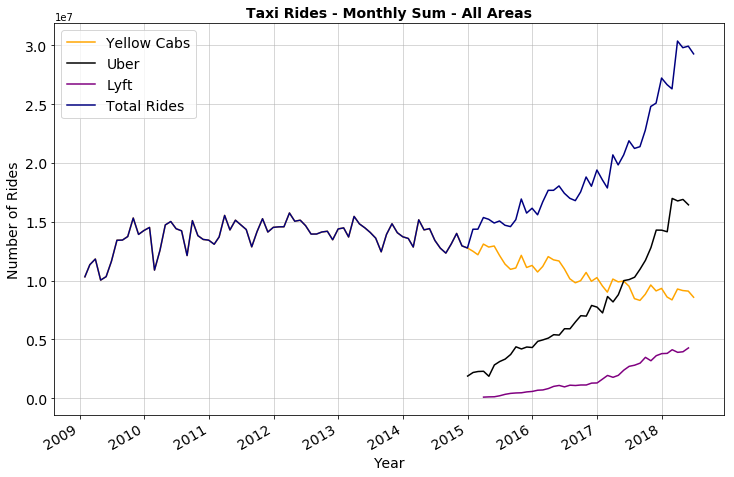

In [17]:
#plot taxi demand vs Uber:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df_m_monthly_sum['total_sum_rides'].loc[:'2018-06'],label='Yellow Cabs', color='orange')
ax.plot(df_FHV_uber['total_rides'].loc[:'2018-06'], label='Uber', color='black')
ax.plot(df_FHV_lyft['total_rides'].loc[:'2018-06'], label='Lyft', color='purple')
#ax.plot(total_rides_df['overall_sum'][:'2018-07'], label='Total Rides', color='navy')
ax.plot(df_yellow_cab_lyft_uber_allrides['overall_sum'].loc[:'2018-06'], label='Total Rides', color='navy')

#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#ax.set_xticklabels(ts_to_plot.index, rotation=50)

ax.set_ylabel('Number of Rides', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Taxi Rides - Monthly Sum - All Areas', fontsize=14, fontweight = 'bold')
ax.xaxis.grid(True, which='minor')
ax.grid(linewidth=0.5)
#ax.legend(fontsize='large')
ax.legend(fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

fig.autofmt_xdate()



### Demand patterns of taxis:

#### plot demand per weekday in manhattan vs residential area:

In [20]:
#returns df with new columns: weekday & hr of day:
def get_weekday_hr_of_ts(ts_series):
    new_df = pd.DataFrame(ts_series.copy())
    new_df['dayofweek'] = new_df.index.day_name()
    new_df['hrofday'] = new_df.index.hour
    
    return new_df
    

In [21]:
#get taxi rides in area 168 (residential area):
ts_to_plot_residential = df_m_all_yellow['116'].copy()

ts_to_plot_residential_df = get_weekday_hr_of_ts(ts_to_plot_residential)


#get taxi rides in area 230:
ts_to_plot_area230 = ts_20largest['230'].copy()

ts_to_plot_area230_df = get_weekday_hr_of_ts(ts_to_plot_area230)

ts_to_plot_area230_df.head()




,230,dayofweek,hrofday
date,,,
2009-01-01 00:00:00,38,Thursday,0
2009-01-01 01:00:00,90,Thursday,1
2009-01-01 02:00:00,119,Thursday,2
2009-01-01 03:00:00,231,Thursday,3
2009-01-01 04:00:00,229,Thursday,4


In [22]:
#get ts for each dayofweek using groupby:

weekdays_per_hr_residential_df = ts_to_plot_residential_df.groupby(['dayofweek','hrofday'])['116'].mean().unstack().T

In [23]:
#get ts for each dayofweek using groupby:

weekdays_per_hr_area230_df = ts_to_plot_area230_df.groupby(['dayofweek','hrofday'])['230'].mean().unstack().T

weekdays_per_hr_area230_df.head()

dayofweek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hrofday,,,,,,,
0,593.824597,297.123232,688.631048,715.797980,496.171371,380.579798,447.200000
1,369.687500,187.890909,519.497984,582.363636,291.264113,230.202020,263.680808
2,237.643145,132.684848,389.145161,459.345455,186.358871,145.654545,166.842424
3,201.756048,127.557576,317.304435,386.701010,161.729839,125.921212,144.476768
4,159.370968,114.424242,184.199597,227.505051,133.991935,107.424242,122.294949


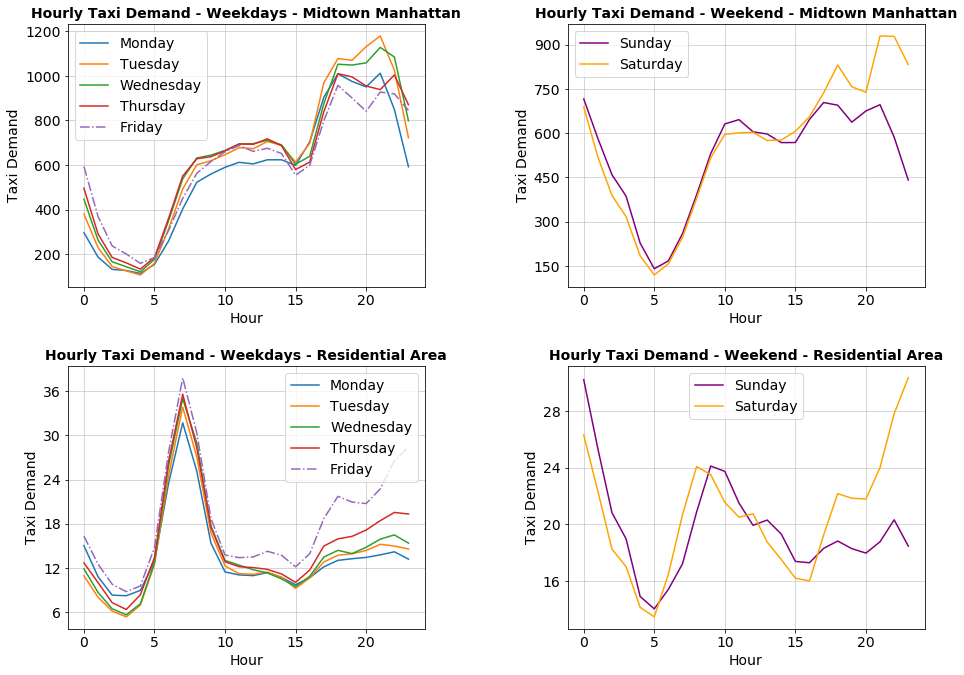

In [26]:
#plot demand per weekday - MANHATTAN:
fig, ax = plt.subplots(2,2,figsize=(14,10))

ax[0,0].plot(weekdays_per_hr_area230_df['Monday'], label='Monday')
ax[0,0].plot(weekdays_per_hr_area230_df['Tuesday'], label='Tuesday')
ax[0,0].plot(weekdays_per_hr_area230_df['Wednesday'], label='Wednesday')
ax[0,0].plot(weekdays_per_hr_area230_df['Thursday'], label='Thursday')
ax[0,0].plot(weekdays_per_hr_area230_df['Friday'], label='Friday', linestyle= '-.')

ax[0,1].plot(weekdays_per_hr_area230_df['Sunday'], label='Sunday', color = 'purple')
#ax[0,1].plot(weekdays_per_hr_area230_df['Friday'], label='Friday', color = 'green')
ax[0,1].plot(weekdays_per_hr_area230_df['Saturday'], label='Saturday', color = 'orange')

ax[1,0].plot(weekdays_per_hr_residential_df['Monday'], label='Monday')
ax[1,0].plot(weekdays_per_hr_residential_df['Tuesday'], label='Tuesday')
ax[1,0].plot(weekdays_per_hr_residential_df['Wednesday'], label='Wednesday')
ax[1,0].plot(weekdays_per_hr_residential_df['Thursday'], label='Thursday')
ax[1,0].plot(weekdays_per_hr_residential_df['Friday'], label='Friday', linestyle= '-.')

ax[1,1].plot(weekdays_per_hr_residential_df['Sunday'], label='Sunday', color = 'purple')
#ax[1,1].plot(weekdays_per_hr_residential_df['Friday'], label='Friday', color = 'green')
ax[1,1].plot(weekdays_per_hr_residential_df['Saturday'], label='Saturday', color = 'orange')



ax[0,0].xaxis.set_major_locator(plt.MaxNLocator(6))
ax[0,1].xaxis.set_major_locator(plt.MaxNLocator(6))
ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(6))
ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(6))

ax[0,0].yaxis.set_major_locator(plt.MaxNLocator(6))
ax[0,1].yaxis.set_major_locator(plt.MaxNLocator(6))
ax[1,0].yaxis.set_major_locator(plt.MaxNLocator(6))
ax[1,1].yaxis.set_major_locator(plt.MaxNLocator(6))

ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,0].tick_params(axis='both', which='minor', labelsize=14)

ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].tick_params(axis='both', which='minor', labelsize=14)

ax[0,1].tick_params(axis='both', which='major', labelsize=14)
ax[0,1].tick_params(axis='both', which='minor', labelsize=14)

ax[1,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].tick_params(axis='both', which='minor', labelsize=14)



ax[0,0].set_xlabel('Hour', fontsize=14)
ax[0,1].set_xlabel('Hour', fontsize=14)
ax[0,0].set_ylabel('Taxi Demand', fontsize=14)
ax[0,1].set_ylabel('Taxi Demand', fontsize=14)
ax[1,0].set_xlabel('Hour', fontsize=14)
ax[1,1].set_xlabel('Hour', fontsize=14)
ax[1,0].set_ylabel('Taxi Demand', fontsize=14)
ax[1,1].set_ylabel('Taxi Demand', fontsize=14)


ax[0,0].legend(fontsize=14)
ax[0,1].legend(fontsize=14)
ax[1,0].legend(fontsize=14)
ax[1,1].legend(fontsize=14)


ax[0,0].grid(linewidth=0.5)
ax[0,1].grid(linewidth=0.5)
ax[1,0].grid(linewidth=0.5)
ax[1,1].grid(linewidth=0.5)

ax[0,0].set_title('Hourly Taxi Demand - Weekdays - Midtown Manhattan', fontsize=14, fontweight='bold')
ax[0,1].set_title('Hourly Taxi Demand - Weekend - Midtown Manhattan', fontsize=14, fontweight='bold')

ax[1,0].set_title('Hourly Taxi Demand - Weekdays - Residential Area', fontsize=14, fontweight='bold')
ax[1,1].set_title('Hourly Taxi Demand - Weekend - Residential Area', fontsize=14, fontweight='bold')


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.4)

plt.show()


### ARIMA vs Canary Predictions

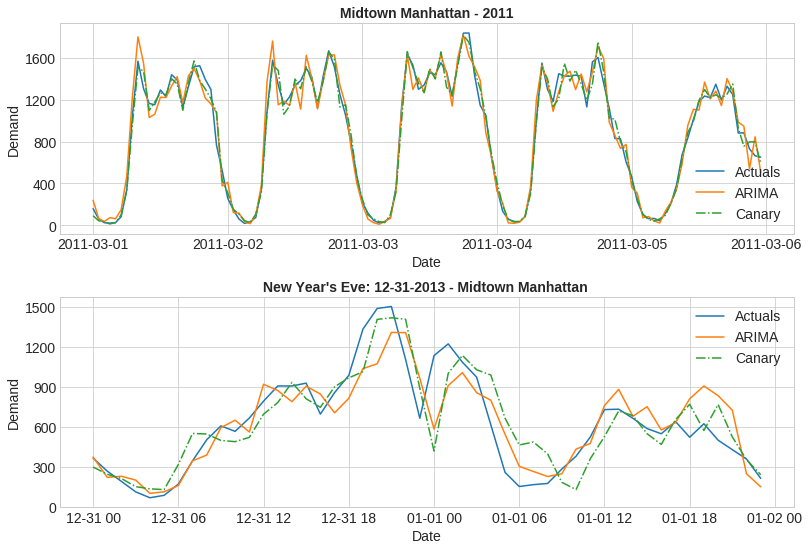

In [41]:
## plot avg STD() & mean() all areas

new_year1 = '2013-12-31'
new_year2 = '2014-01-01'

fig1, ax1 = plt.subplots(2,1, figsize=(12,8))

ax1[0].plot(ts_20largest.loc['2011-03-01':'2011-03-05'].iloc[:,0], label='Actuals')
ax1[0].plot(ARIMA_2404_preds_20largest_areas__2years.loc['2011-03-01':'2011-03-05'].iloc[:,0], label='ARIMA')
ax1[0].plot(canary_preds_20largest_areas__2years.loc['2011-03-01':'2011-03-05'].iloc[:,0], label='Canary', linestyle= '-.')

ax1[1].plot(ts_20largest.loc[new_year1:new_year2].iloc[:,6], label='Actuals')
ax1[1].plot(ARIMA_2404_preds_20largest_areas__2years.loc[new_year1:new_year2].iloc[:,6], label='ARIMA') #10, 2, 8, 4, 6,
ax1[1].plot(canary_preds_20largest_areas__2years.loc[new_year1:new_year2].iloc[:,6], label='Canary', linestyle= '-.')


ax1[0].set_ylabel('Demand', fontsize=14)
ax1[0].set_xlabel('Date', fontsize=14)
ax1[0].legend(fontsize=14)
ax1[0].set_title('Midtown Manhattan - 2011', fontsize=14, fontweight = 'bold')


ax1[0].tick_params(axis='both', which='major', labelsize=14)
ax1[0].tick_params(axis='both', which='minor', labelsize=14)

ax1[1].tick_params(axis='both', which='major', labelsize=14)
ax1[1].tick_params(axis='both', which='minor', labelsize=14)


ax1[0].yaxis.set_major_locator(plt.MaxNLocator(6))
ax1[1].yaxis.set_major_locator(plt.MaxNLocator(6))

ax1[1].set_ylabel('Demand', fontsize=14)
ax1[1].set_xlabel('Date', fontsize=14)
ax1[1].legend(fontsize=14)
ax1[1].set_title("New Year's Eve: 12-31-2013 - Midtown Manhattan ", fontsize=14, fontweight = 'bold')


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.4)


plt.show()


### Variance in Demand

In [8]:
#get avg. monthly variance among all areas:

area_list = list(ts_20largest.columns)

overall_monthly_std_all_areas_df = pd.DataFrame()

overall_monthly_mean_all_areas_df = pd.DataFrame()

#get rolling std per area:
for i in range(len(area_list)):
    
    single_ts = ts_20largest.iloc[:,i].copy()
    
    std_series_area_i = single_ts.resample('M').std()
    
    mean_series_area_i = single_ts.resample('M').mean()
    
    overall_monthly_std_all_areas_df[area_list[i]] = std_series_area_i
    
    overall_monthly_mean_all_areas_df[area_list[i]] = mean_series_area_i
    
    
#get avg across all series:
overall_monthly_std_all_areas_df['overall_avg'] = overall_monthly_std_all_areas_df.mean(axis=1)
overall_monthly_mean_all_areas_df['overall_avg'] = overall_monthly_mean_all_areas_df.mean(axis=1)
 
  

In [9]:
#get ratio of std and overall mean:
std_mean_ratio = overall_monthly_std_all_areas_df['overall_avg'] / overall_monthly_mean_all_areas_df['overall_avg']


In [115]:
std_mean_ratio.head()

date
2009-01-31    0.607775
2009-02-28    0.592694
2009-03-31    0.589143
2009-04-30    0.577532
2009-05-31    0.572651
Freq: M, Name: overall_avg, dtype: float64

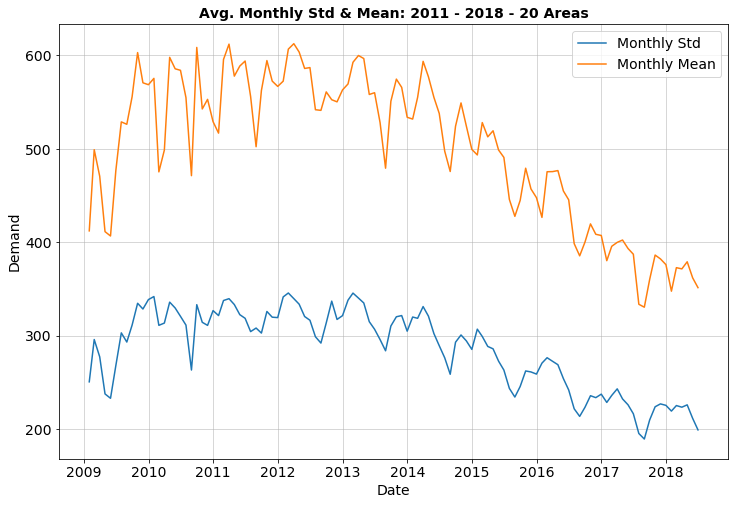

In [48]:
## plot avg STD() & mean() all areas

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(overall_monthly_std_all_areas_df['overall_avg'], label='Monthly Std')
ax1.plot(overall_monthly_mean_all_areas_df['overall_avg'], label='Monthly Mean')

ax1.set_ylabel('Demand', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.legend(fontsize=14)
ax1.set_title('Avg. Monthly Std & Mean: 2011 - 2018 - 20 Areas', fontsize=14, fontweight = 'bold')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

ax1.grid(linewidth=0.5)

plt.show()


In [10]:
def get_lowess_curve(single_ts_series):

    ts_to_lowess = pd.DataFrame(single_ts_series.copy())
    ts_to_lowess.reset_index(inplace=True)

    lowess = sm.nonparametric.lowess(single_ts_series, ts_to_lowess.index, frac=.66)

    # unpack the lowess smoothed points to their values
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]


    lowess_to_plot_df = pd.DataFrame(single_ts_series.copy())
    lowess_to_plot_df['lowess_y'] = lowess_y
    #lowess_to_plot_df.head()
    
    return lowess_to_plot_df

In [117]:
std_mean_ratio.head()

date
2009-01-31    0.607775
2009-02-28    0.592694
2009-03-31    0.589143
2009-04-30    0.577532
2009-05-31    0.572651
Freq: M, Name: overall_avg, dtype: float64

In [74]:
## plot std/Mean reatio all areas

std_mean_ratio_df = pd.DataFrame(std_mean_ratio)
std_mean_ratio_df.columns= ['ratio']

#call function to get lowess curve:
lowess_to_plot_df = get_lowess_curve(std_mean_ratio_df['ratio'])

std_mean_ratio_df['lowess'] = lowess_to_plot_df['lowess_y']
std_mean_ratio_df['rolling_mean'] = std_mean_ratio_df['ratio'].rolling(3).mean()



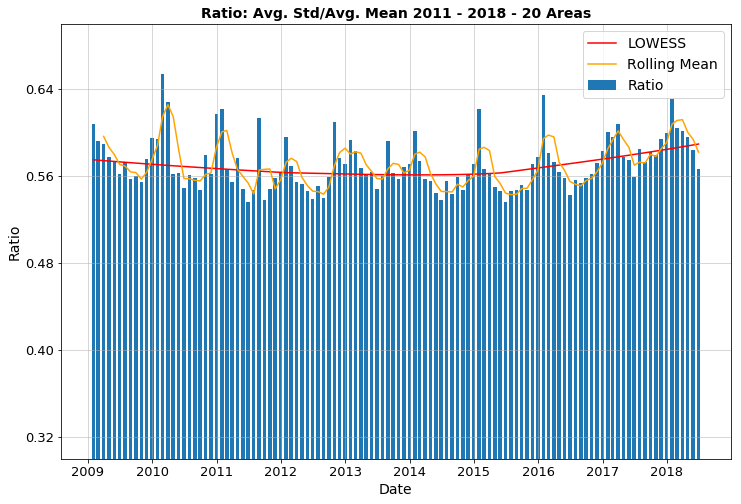

In [121]:
fig1, ax1 = plt.subplots(figsize=(12,8))

ax1.bar(std_mean_ratio_df.index, std_mean_ratio_df['ratio'], width=20., label='Ratio')
ax1.plot(lowess_to_plot_df['lowess_y'], label='LOWESS', color='red')
ax1.plot(std_mean_ratio_df['rolling_mean'], label='Rolling Mean', color='orange')

ax1.set_ylim(0.3,0.7)

ax1.set_xlabel('Dates')
ax1.set_ylabel('Ratio', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.legend(fontsize=14)
ax1.set_title('Ratio: Avg. Std/Avg. Mean 2011 - 2018 - 20 Areas', fontsize=14, fontweight = 'bold')

ax1.grid(linewidth=0.5)

#ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=7)) 
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator()) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.tick_params(axis='both', which='minor', labelsize=11)

ax1.yaxis.set_major_locator(plt.MaxNLocator(6))

#plt.setp(ax1.xaxis.get_majorticklabels())

#ax1.xaxis_date()

plt.show()


## Polygon Plot

In [7]:
#get data of all areas & resample data to demand for each area:

#necessary to set index of df_m:
df_m_all_yellow = df_m.set_index("date").copy()
#set index correctly to local time:
df_m_all_yellow.index = df_m_all_yellow.index.shift(-5,freq='H')


#get total demand (sum) for each area:
df_m_all_yellow_sum = df_m_all_yellow.sum(axis=0)



In [8]:
#create dataFrame of df_m_all_yellow_sum which contains columns for LocationID & Demand 
#--> columns necessary to join with shape file!

df_m_all_yellow_sum = pd.DataFrame(df_m_all_yellow_sum)

#reset index to obtain LocationID:
df_m_all_yellow_sum.reset_index(inplace=True)

df_m_all_yellow_sum.columns = ['LocationID','Demand']

#change type of data:
df_m_all_yellow_sum['LocationID'] = df_m_all_yellow_sum['LocationID'].astype('int64')


#get percentile rank per entry:
df_m_all_yellow_sum['percentile_rank'] = df_m_all_yellow_sum['Demand'].rank(pct=True)

In [9]:
#merge df with polygons of shapefile:

merged_taxi_demand_df = taxi_shapefile.merge(df_m_all_yellow_sum, left_on='LocationID', right_on='LocationID', how='left')



In [94]:
merged_taxi_demand_df.head()

,zone,LocationID,borough,geometry,Demand,percentile_rank
0,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999993...,118582,0.577947
1,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,11349,0.212928
2,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399996...,7391,0.136882
3,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133709...,5076807,0.817490
4,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599993...,1036,0.019011


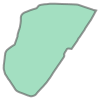

In [53]:
merged_taxi_demand_df['geometry'].iloc[0]

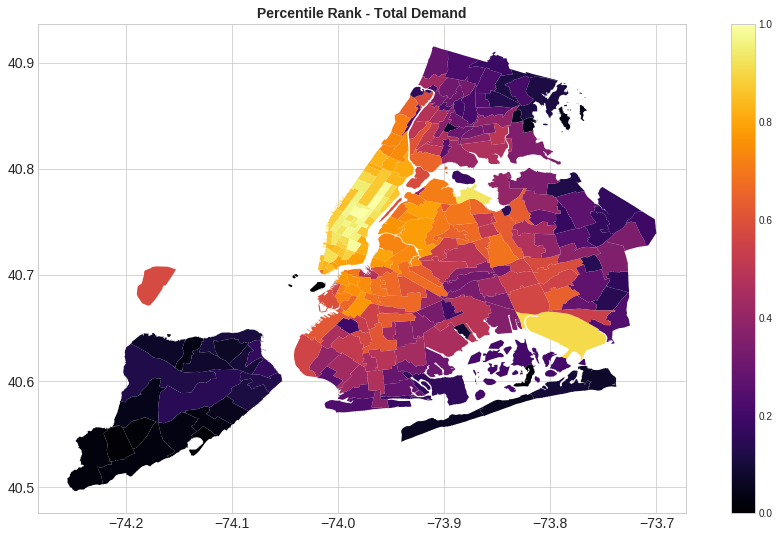

In [112]:
variable_to_plot = 'percentile_rank'

fig1, ax1 = plt.subplots(figsize=(16,9))

#set range of values for bar:
vmin, vmax = 0, 1

scalm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
scalm.set_array([])

#fig1.colorbar(sm)

cbar = plt.colorbar(scalm)
#cbar.set_label('Percentile Rank Total Demand', rotation=90, fontsize=14)
#cbar.tick_labels('Percentile Rank Total Demand', fontsize=14)

merged_taxi_demand_df.plot(column= variable_to_plot, cmap='inferno', ax=ax1)

ax1.set_title('Percentile Rank - Total Demand', fontsize=14, fontweight = 'bold')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

plt.show()


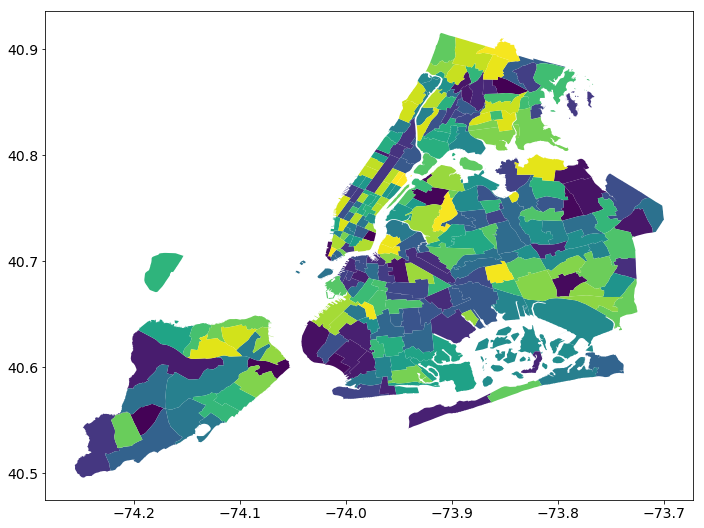

In [19]:
variable_to_plot = 'zone'

fig1, ax1 = plt.subplots(figsize=(16,9))

#cbar.set_label('Percentile Rank Total Demand', rotation=90, fontsize=14)
#cbar.tick_labels('Percentile Rank Total Demand', fontsize=14)

merged_taxi_demand_df.plot(column= variable_to_plot, cmap='viridis', ax=ax1)

#ax1.set_title('Percentile Rank - Total Demand', fontsize=14, fontweight = 'bold')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

plt.show()



## Drift Plots: Blizzard, Baseball, Pride, New Years Eve

#### New Years Eve

In [18]:
#necessary to set index of df_m:
df_m_all_yellow = df_m.set_index("date").copy()
#set index correctly to local time:
df_m_all_yellow.index = df_m_all_yellow.index.shift(-5,freq='H')

In [105]:
#--> New years Eve in area 246:
ts_new_years_eve = df_m_all_yellow['246'].copy()

#ts_new_years_eve_to_plot = ts_new_years_eve['2016-12-29-00':'2017-01-01-01']
ts_new_years_eve_to_plot = ts_new_years_eve['2011-12-29-00':'2012-01-01-01']

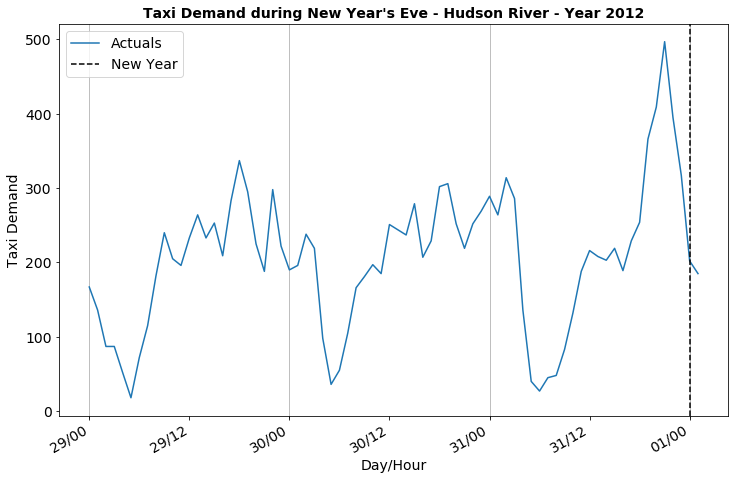

In [107]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ts_new_years_eve_to_plot,label='Actuals')
#ax.plot(ts_to_plot['lowess_y'], label='lowess')

#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%H"))
ax.axvline(x=pd.Timestamp('2012-01-01-00'), label='New Year', color='k', linestyle='--')
ax.set_title("Taxi Demand during New Year's Eve - Hudson River - Year 2012", fontsize=14, fontweight='bold')
ax.set_xlabel('Day/Hour', fontsize=14)
ax.set_ylabel('Taxi Demand', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.yaxis.set_major_locator(plt.MaxNLocator(6))

#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.grid(True, which='minor')
ax.legend(fontsize=14)
fig.autofmt_xdate()


##### new year 2017

In [109]:
ts_new_years_eve_to_plot = ts_new_years_eve['2016-12-29-00':'2017-01-01-01']

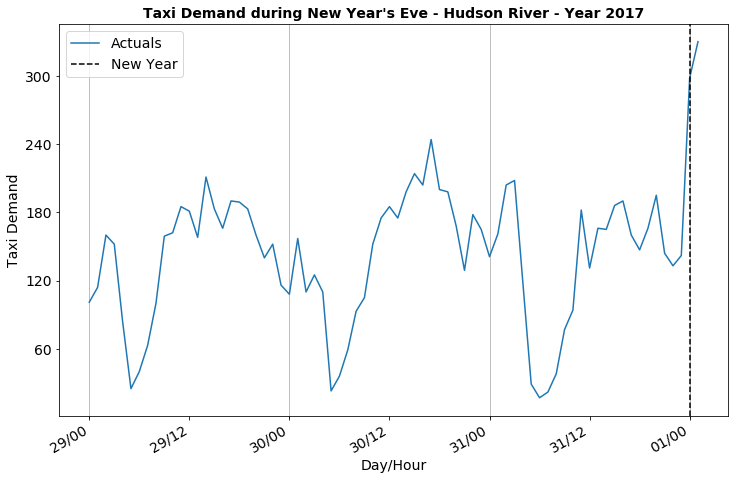

In [110]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ts_new_years_eve_to_plot,label='Actuals')
#ax.plot(ts_to_plot['lowess_y'], label='lowess')

#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%H"))
ax.axvline(x=pd.Timestamp('2017-01-01-00'), label='New Year', color='k', linestyle='--')
ax.set_title("Taxi Demand during New Year's Eve - Hudson River - Year 2017", fontsize=14, fontweight='bold')
ax.set_xlabel('Day/Hour', fontsize=14)
ax.set_ylabel('Taxi Demand', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.yaxis.set_major_locator(plt.MaxNLocator(6))

#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.grid(True, which='minor')
ax.legend(fontsize=14)
fig.autofmt_xdate()


#### Blizzard Plot

In [22]:
#returns df with new columns: weekday & hr of day:
def get_weekday_hr_of_ts(ts_series):
    new_df = pd.DataFrame(ts_series.copy())
    new_df['dayofweek'] = new_df.index.day_name()
    new_df['hrofday'] = new_df.index.hour
    
    return new_df
    

In [21]:
#Blizzard in 2015-01-27 --> (Tuesday!! ):

#get taxi rides in area 237 manhattan during blizzard and avg. taxi rides on Tuesdays:
ts_blizzard = df_m_all_yellow['237'].copy()

#get df with weekdays and hrs (call function):
ts_blizzard_df = get_weekday_hr_of_ts(ts_blizzard)

ts_blizzard_df.head()

,237,dayofweek,hrofday
date,,,
2009-01-01 00:00:00,331,Thursday,0
2009-01-01 01:00:00,323,Thursday,1
2009-01-01 02:00:00,210,Thursday,2
2009-01-01 03:00:00,133,Thursday,3
2009-01-01 04:00:00,55,Thursday,4


In [23]:
ts_blizzard_df['single_date'] = ts_blizzard_df.index.date

In [24]:

ts_blizzard_df.head()

,237,dayofweek,hrofday,single_date
date,,,,
2009-01-01 00:00:00,331,Thursday,0,2009-01-01
2009-01-01 01:00:00,323,Thursday,1,2009-01-01
2009-01-01 02:00:00,210,Thursday,2,2009-01-01
2009-01-01 03:00:00,133,Thursday,3,2009-01-01
2009-01-01 04:00:00,55,Thursday,4,2009-01-01


In [25]:
#get avg. Taxi rides 
ts_df_avg_Tuesdays = pd.DataFrame(ts_blizzard_df[ts_blizzard_df['dayofweek'] == 'Tuesday'].groupby(['hrofday'])['237'].mean())

#add quantiles:
ts_df_avg_Tuesdays['Q25'] = ts_blizzard_df[ts_blizzard_df['dayofweek'] == 'Tuesday'].groupby(['hrofday'])['237'].quantile(q=0.25)
ts_df_avg_Tuesdays['Q75'] = ts_blizzard_df[ts_blizzard_df['dayofweek'] == 'Tuesday'].groupby(['hrofday'])['237'].quantile(q=0.75)

#get day on which blizzard happened:
ts_blizzard_Tuesday = ts_blizzard_df['2015-01-27']


#restore index of ts_blizzard_df_avg_Tuesdays:
ts_df_avg_Tuesdays.index = ts_blizzard_Tuesday.index

In [53]:
ts_df_avg_Tuesdays.head()

,237,Q25,Q75
date,,,
2015-01-27 00:00:00,102.836364,61.0,128.5
2015-01-27 01:00:00,49.688889,30.5,56.5
2015-01-27 02:00:00,26.808081,17.0,31.0
2015-01-27 03:00:00,26.579798,20.0,31.0
2015-01-27 04:00:00,67.450505,30.0,95.5


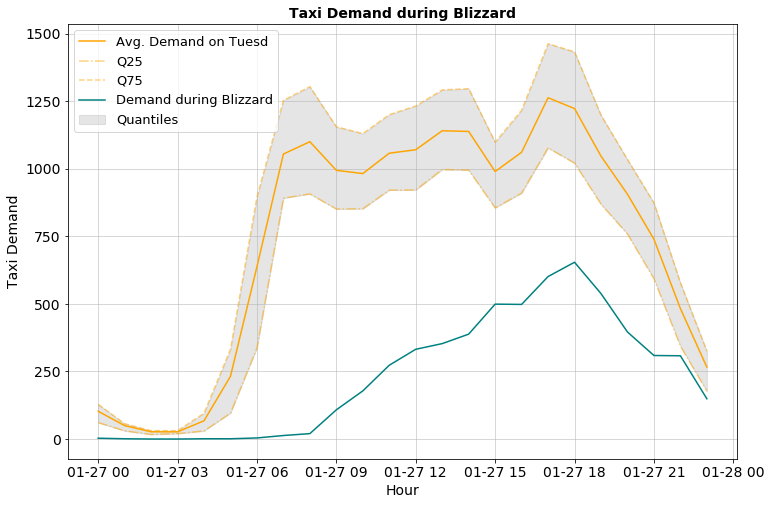

In [28]:
#plot blizzards:

fig, axarr = plt.subplots(figsize=(12, 8))
axarr.plot(ts_df_avg_Tuesdays['237'],label='Avg. Demand on Tuesd', color='orange')
axarr.plot(ts_df_avg_Tuesdays['Q25'], color='orange', alpha=0.5, linestyle = '-.')
axarr.plot(ts_df_avg_Tuesdays['Q75'], color='orange', alpha=0.5, linestyle = '--')
axarr.fill_between(ts_df_avg_Tuesdays['237'].index, ts_df_avg_Tuesdays['Q25'], ts_df_avg_Tuesdays['Q75'], color='grey', alpha=0.2, label='Quantiles')

axarr.plot(ts_blizzard_Tuesday['237'],label='Demand during Blizzard', color='teal')

axarr.legend(fontsize=13)
axarr.set_title("Taxi Demand during Blizzard", fontsize=14, fontweight='bold')
axarr.set_xlabel('Hour', fontsize=14)
axarr.set_ylabel('Taxi Demand', fontsize=14)


axarr.tick_params(axis='both', which='major', labelsize=14)
axarr.tick_params(axis='both', which='minor', labelsize=14)

axarr.yaxis.set_major_locator(plt.MaxNLocator(7))
axarr.grid(linewidth=0.5)

plt.show()

fig.autofmt_xdate()


#### Trendy district Williamsburg:

In [66]:
#get taxi rides in area 68 Chelsea :
#East Village: 79
#Williamsburg: 255/256

ts_to_plot_trendy_area1 = df_m_all_yellow['68'].copy()

ts_to_plot_trendy_area1 = ts_to_plot_trendy_area1.rolling(168*2).mean()

ts_to_plot_trendy_area1.dropna(inplace=True)


#get second trendy area:
ts_to_plot_trendy_area2 = df_m_all_yellow['256'].copy()

ts_to_plot_trendy_area2 = ts_to_plot_trendy_area2.rolling(168*2).mean()

ts_to_plot_trendy_area2.dropna(inplace=True)




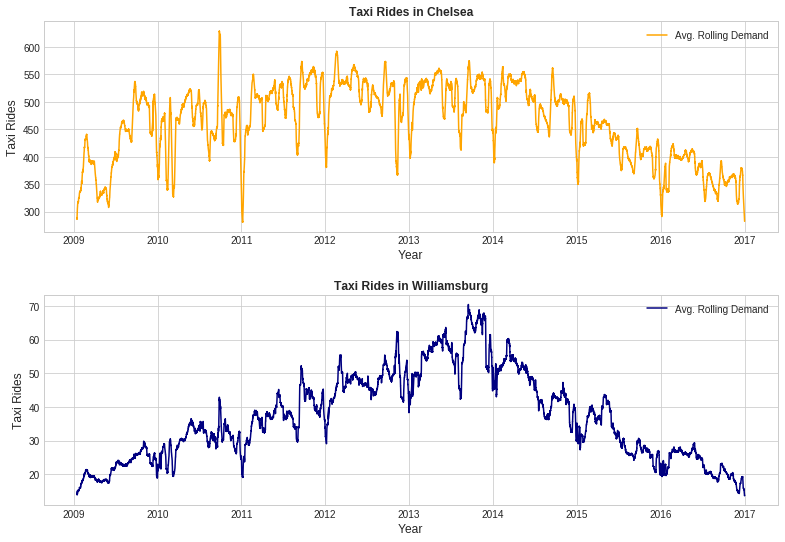

In [78]:
fig, axarr = plt.subplots(2,1,figsize=(12, 8))
axarr[0].plot(ts_to_plot_trendy_area1['2009':'2016'],label='Avg. Rolling Demand', color='orange')
axarr[1].plot(ts_to_plot_trendy_area2['2009':'2016'],label='Avg. Rolling Demand', color='navy')

axarr[0].legend()
axarr[0].set_title("Taxi Rides in Chelsea", fontsize=12, fontweight='bold')
axarr[0].set_xlabel('Year', fontsize=12)
axarr[0].set_ylabel('Taxi Rides', fontsize=12)

axarr[1].legend()
axarr[1].set_title("Taxi Rides in Williamsburg", fontsize=12, fontweight='bold')
axarr[1].set_xlabel('Year', fontsize=12)
axarr[1].set_ylabel('Taxi Rides', fontsize=12)


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

plt.show()


#### Lagged vs Hist Plot

In [6]:
lag_df = pd.DataFrame(ts_10largest['237'].loc['2009'].copy())


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


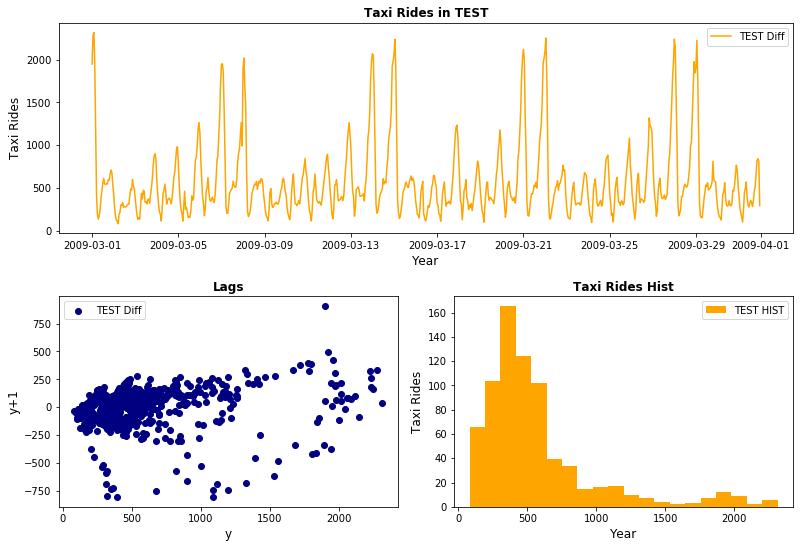

In [27]:
fig = plt.figure(figsize=(12, 8))

gs = gridspec.GridSpec(2, 4) 

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :2])
ax3 = plt.subplot(gs[1, 2:])


ax1.plot(ts_10largest['79'].loc['2009-03'], label='TEST Diff', color='orange')
ax2.scatter(y= ts_10largest['79'].loc['2009-03'].diff(1), x=ts_10largest['79'].loc['2009-03'], label='TEST Diff', color='navy')
ax3.hist(ts_10largest['79'].loc['2009-03'], bins=20, label='TEST HIST', color='orange')

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_title("Taxi Rides in TEST", fontsize=12, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Taxi Rides', fontsize=12)

ax2.set_title("Lags", fontsize=12, fontweight='bold')
ax2.set_xlabel('y', fontsize=12)
ax2.set_ylabel('y+1', fontsize=12)


ax3.set_title("Taxi Rides Hist", fontsize=12, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Taxi Rides', fontsize=12)


plt.tight_layout()


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.4)

plt.show()


#save fig:
#df_20areas_preds_PATH = '/media/vincent/harddrive/ML-Projects_all/NY_Cab_Project/NY_Cab_Data/results/Stacked_LSTM/Hyperparam_tuning_y2011/Plots_20largest_areas_models/'
#fig.savefig(df_20areas_preds_PATH + 'Rolling_Demand_in_trendy_areas.jpeg', dpi=196)
